In [2]:
import numpy as np
import json
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
def cost_function(x, G):
    obj = 0
    for i, j in G.edges():
        if x[i] * x[j] == 1:
            obj += 2
    return - sum(x) + obj

def greedy_qubo_solver(G, current=None, max_iter=1000):
    nq =  G.number_of_nodes()
    if type(current) == str:
        current = np.array([int(i) for i in current])
    else:
        current = np.random.choice([0, 1], size=nq)
    best = current.copy()
    best_cost = cost_function(best, G)
    bitflips = 0
    for _ in range(max_iter):
        nq_list = list(range(nq))
        # np.random.shuffle(nq_list)
        for i in nq_list:
            candidate = current.copy()
            candidate[i] ^= 1
            current_cost = cost_function(candidate, G)
            if current_cost < best_cost:
                best = candidate.copy()
                best_cost = current_cost
                current = candidate
                bitflips += 1
    best_bitstring = ''.join(str(b) for b in best)
    return best_bitstring, best_cost, bitflips

In [ ]:
backend_name = "quera_aquila"
# backend_name = "pasqal_fresnel"

nq = 41
num_sweeps = 2
time = 1e-6
extra = f"_t_{time}"
method = "QA"
with open(f"./Data/{backend_name}/{method}/{nq}{extra}.json", "r") as file:
    result = json.load(file)

with open(f"./Data/problems/{nq}.json", "r") as file:
    problem = json.load(file)

G = nx.Graph()
G.add_nodes_from(range(nq))
G.add_edges_from(problem["edges"])
seed = 0
min_cost = result["min_cost"]
result["greedy_cost"] = defaultdict(int)
result["greedy"] = defaultdict(int)
for sample, count in result["samples"].items():
    current_cost = cost_function(np.array([int(i) for i in sample]), G)
    new_sample, new_cost, bitflips = greedy_qubo_solver(G, sample, max_iter=num_sweeps)
    result["greedy_cost"][int(new_cost)] += count
    if new_cost <= min_cost:
        result["greedy"][bitflips]+= count

with open(f"./Data/{backend_name}/{method}/{nq}{extra}.json", "w") as file:
    json.dump(result, file)

Text(0, 0.5, '%')

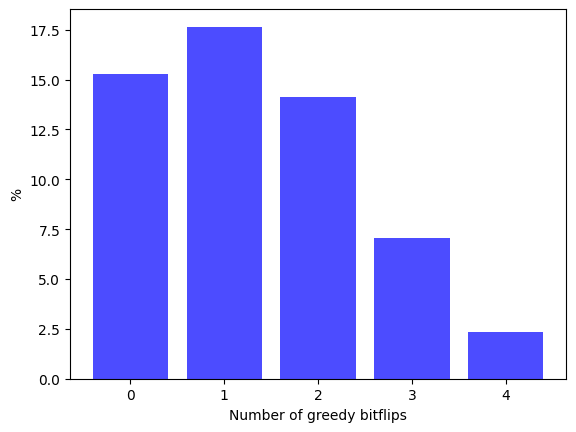

In [52]:
fig, ax = plt.subplots()
ax.bar(result["greedy"].keys(), 100*np.array(list(result["greedy"].values()))/sum(result["samples"].values()), width=0.8, color='blue', alpha=0.7)
ax.set_xlabel('Number of greedy bitflips')
ax.set_ylabel('%')